# Exploratory data analysis of Auckland rainfall data


In this notebook, I am applying EDA methods to analyse rainfall data in Auckland between 1872 and 1997 and summarise the main results. 

A set of tables was taken from the Auckland Council website: 
<a href="https://environmentauckland.org.nz/Data/DataSet/Summary/Location/A64871M/DataSet/Rainfall/Continuous/Interval/Latest">Link to Website</a> Five tables contain the daily amount of rainfall  in millimetres, measured at two different locations: Mt Albert and City centre. The tables cover various time intervals starting from 6 years to 140 years, and they include both measured values and synthesized data. 

We will explore here one of the data files, A64871M, covering a period between 1872 and 1997. The table is named AucklandRainfall1872-1997.csv, and it contains five columns and 31652 rows, but only two columns are needed for our analysis:  dates and the amount of rain in millimeters. The dates are given for NZST (UTC +12h) time zone. The frequency of the measurements is between 1 and 10 days. 

### 1. Importing Python libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
import calendar
from dateutil import tz

import matplotlib.pyplot as plt
import statsmodels as sm

#setting plot style
plt.style.use('seaborn')

#setting plot size
plt.rcParams['figure.figsize'] = [14,8]

### 2. Reading input file

To read the rain data, we will use the Panda's function pd.read_csv(). 

In [2]:
%%time
file = '../Data/AucklandRainfall1872-1997.csv'

rain=pd.read_csv(file, skiprows=3, header=None,
                  names=['Date','rain_value', 'grade', 'interpol_type', 'event_timestamp'],
                  parse_dates=['Date'],
                  index_col='Date')
rain.head(5)

Wall time: 40.7 ms


,rain_value,grade,interpol_type,event_timestamp
Date,,,,
1872-01-03,0.00,200,5,NaN
1872-01-04,3.81,200,5,NaN
1872-01-05,2.03,200,5,NaN
1872-01-09,0.00,200,5,NaN
1872-01-10,0.51,200,5,NaN


### 3. Removing unnecessary columns

Three columns: grade, interpol_type, and event_timestamp have the same values throughout the table. At this stage of the analysis, we can remove them from the table. 

In [3]:
#count unique values
display(rain['grade'].value_counts(sort = True, normalize = True))
display(rain['interpol_type'].value_counts(sort=True, normalize = True))
display(rain['event_timestamp'].value_counts(sort=True, normalize = True))
    
rain = rain.drop(columns = ['event_timestamp', 'grade', 'interpol_type'])

200    1.0
Name: grade, dtype: float64

5    1.0
Name: interpol_type, dtype: float64

Series([], Name: event_timestamp, dtype: float64)

### 4. Displaying remaining columns

In [4]:
rain.info()
rain.tail(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31652 entries, 1872-01-03 00:00:00 to 1997-09-30 08:30:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_value  31652 non-null  float64
dtypes: float64(1)
memory usage: 494.6 KB


,rain_value
Date,
1997-09-24 08:30:00,63.4
1997-09-25 08:30:00,15.0
1997-09-26 08:30:00,0.4
1997-09-29 08:30:00,80.2
1997-09-30 08:30:00,19.3


### 5. Exploring Date column

The Date column was not set to include a timezone. We will set a time zone for the DateTime index column relative to the UTC time, by using the IANA database and dateutil library. The timezone database is updated regularly and includes daylight savings and other time zone changes, which are especially important when we are working with datasets spread over a long time period. By exploring the Date column, we can find that only one measurement was recorded per day and that on about 30% of days, the amount of rain was not documented. 

In [5]:
%%time
#timezone information
rain.index.tzinfo

#setting the local timezone
rain_tz = rain.copy() 

#original date column
rain_tz['Date_naive'] = rain_tz.index

#timezone offset relative to UTC 
rain_tz = rain_tz.tz_localize(tz = tz.gettz('Pacific/Auckland'))
display(rain_tz.head(2))

print('Start date: ', min(rain_tz.index), 'End date: ', max(rain_tz.index))
print('Unique dates:', len(rain_tz.index.unique()), '.v.s. Total number of dates:', rain_tz.shape[0])

delta = max(rain_tz.index)-min(rain_tz.index)
no_measurements = delta.days-rain_tz.shape[0]
print('Total number of days:', delta.days, '.vs. Number of days without measurements:',no_measurements, '---', round(no_measurements/delta.days*100, 0), ' %')

,rain_value,Date_naive
Date,,
1872-01-03 00:00:00+11:39:04,0.00,1872-01-03
1872-01-04 00:00:00+11:39:04,3.81,1872-01-04


Start date:  1872-01-03 00:00:00+11:39:04 End date:  1997-09-30 08:30:00+12:00
Unique dates: 31652 .v.s. Total number of dates: 31652
Total number of days: 45926 .vs. Number of days without measurements: 14274 --- 31.0  %
Wall time: 258 ms


### 6. Exploring the rain_value column

By exploring the rain_value column we can find number of days with the zerro amount of rain and also the dates with the maximum rainfall. 

In [6]:
%%time
#frequency of rain values
rain_days = rain_tz['rain_value'].value_counts(dropna = True, sort = True)

print('Number of days without rain:', rain_days[0], '---', round(rain_days[0]/rain_tz.shape[0] *100, 0),'%')

#dates with the maximum rainfalls:
rain_sorted = rain_tz.sort_values(by = 'rain_value', ascending=False)
display(rain_sorted.head(5))

Number of days without rain: 8473 --- 27.0 %


,rain_value,Date_naive
Date,,
1936-02-02 00:00:00+12:00,162.05,1936-02-02
1985-05-23 00:00:00+12:00,156.60,1985-05-23
1979-02-18 00:00:00+13:00,142.20,1979-02-18
1917-02-04 00:00:00+11:30,140.72,1917-02-04
1989-08-26 00:00:00+12:00,133.30,1989-08-26


Wall time: 13.9 ms


In [7]:
#distribution of numbers
rain.describe()

,rain_value
count,31652.000000
mean,4.723530
std,9.145826
min,0.000000
25%,0.000000
50%,1.270000
75%,5.330000
max,162.050000


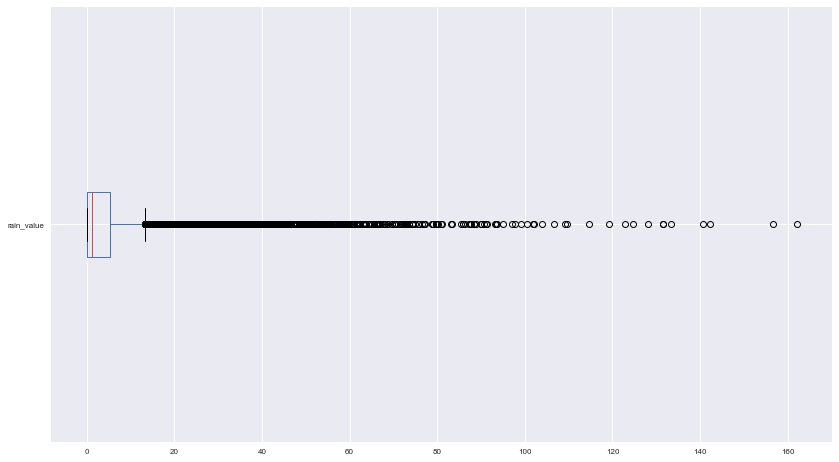

In [8]:
rain.boxplot(fontsize=8, vert=False)
plt.show()

### 7. Finding number of days with little rain

After excluding dates recorded as days with zero rain, we can find out how many days have rainfall less than 20 mm per day. 

In [9]:
#amount of rain per day in mm
rain_c = 20

rain_sorted = rain_days.sort_index()

#values of rain between 0.1 and rain_c
days_no = rain_sorted[rain_sorted.index[1]:rain_c].values.sum()

#percentage of days with rain_c 
rain_perc = round(days_no/rain_tz.shape[0]*100, 0)

print('Number of days with rain less than', rain_c, ' mm/day:', days_no, '---', rain_perc, '%', '\n')

Number of days with rain less than 20  mm/day: 21512 --- 68.0 % 



### 8. Plotting three different time intervals

We will plot three selected intervals, each two years long, from the start of the data set, middle, and the end of the file. If we assume that all rain values were collected in the same way and that all zero points represent days without rain, then we can expect to see seasonal changes across a year plus variations from year to year. 

Wall time: 40.5 ms


Text(0.5, 1.0, 'Auckland rainfall in mm')

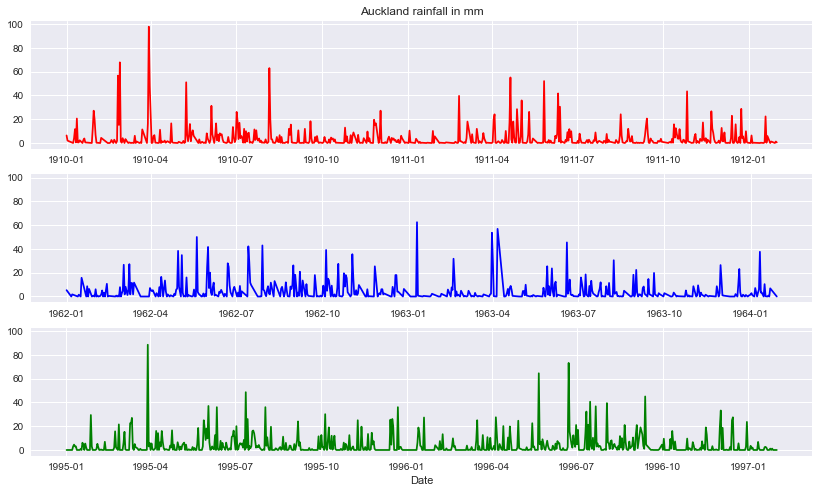

In [10]:
%%time
rain_1012 = rain['1910-01': '1912-01']
rain_6264 = rain['1962-01': '1964-01']
rain_9597 = rain['1995-01': '1997-01']

fig,ax = plt.subplots(3,1, sharey=True)
ax[0].plot(rain_1012.index, rain_1012['rain_value'], color = 'red')
ax[1].plot(rain_6264.index, rain_6264['rain_value'], color = 'blue')
ax[2].plot(rain_9597.index, rain_9597['rain_value'], color = 'green')

ax[2].set_xlabel('Date')
ax[0].set_title('Auckland rainfall in mm')

### 9. Plotting missing dates

We can explore whether the dates with no measurements are distributed evenly across data, or whether they are concentrated at  some periods. For example, we will look at the rainfall data showing a deep on the mean resample plot around the year 1914. 

,rain_value,missing
1913-01-01,0.00,NaN
1913-01-02,2.29,NaN
1913-01-03,0.76,NaN
1913-01-04,2.54,NaN
1913-01-05,0.00,NaN


Text(0.5, 1.0, 'Measured rainfall values and dates with no data')

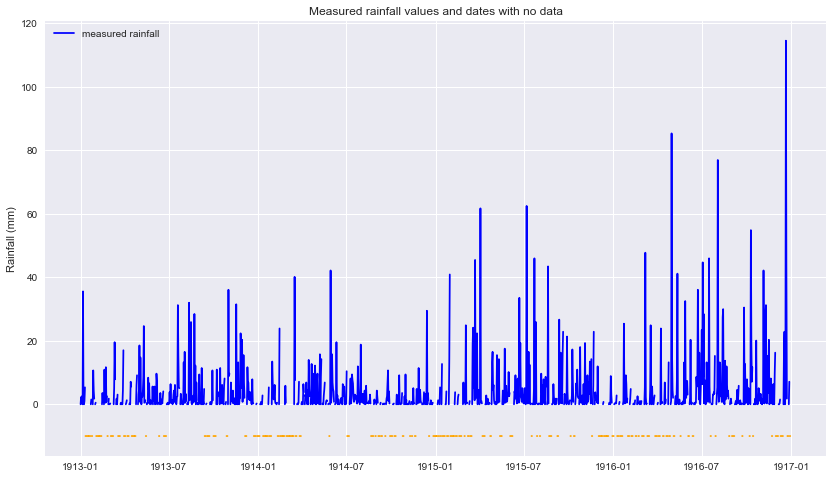

In [11]:
#resampling/reindexing data
rn = pd.date_range(start = min(rain.index), end = max(rain.index))
rain1 = rain.reindex(rn).fillna(-10)

#creating two columns and assigning -10 to missing dates
rain1['missing'] = rain1[rain1.rain_value==-10]
rain1['rain_value'] = rain1[rain1.rain_value!=-10]

rain1 = rain1['1913':'1916']
display(rain1.head(5))

fig,ax = plt.subplots()
ax.plot(rain1.index, rain1['rain_value'], color ='blue')
ax.plot(rain1.index, rain1['missing'], color ='orange')

ax.set_ylabel('Rainfall (mm)')
ax.legend(['measured rainfall'])
ax.set_title('Measured rainfall values and dates with no data')

### 10. Resampling data

To find  patterns and trends in data, we can resample rain data to the mean monthly and annual values. The annual plot shows low rainfall values around 1914 and 1915, indicating eighter a low amount of rain during this period or no rainfall data records.

,rain_value
Date,
1872-01-31,0.917692
1872-02-29,6.810909
1872-03-31,5.115714
1872-04-30,5.624815
1872-05-31,3.402800


,rain_value
Date,
1872-12-31,4.456820
1873-12-31,4.429283
1874-12-31,3.863617
1875-12-31,4.938923
1876-12-31,4.053715


Wall time: 71.6 ms


Text(0.5, 1.0, 'Mean monthly and annual rainfall')

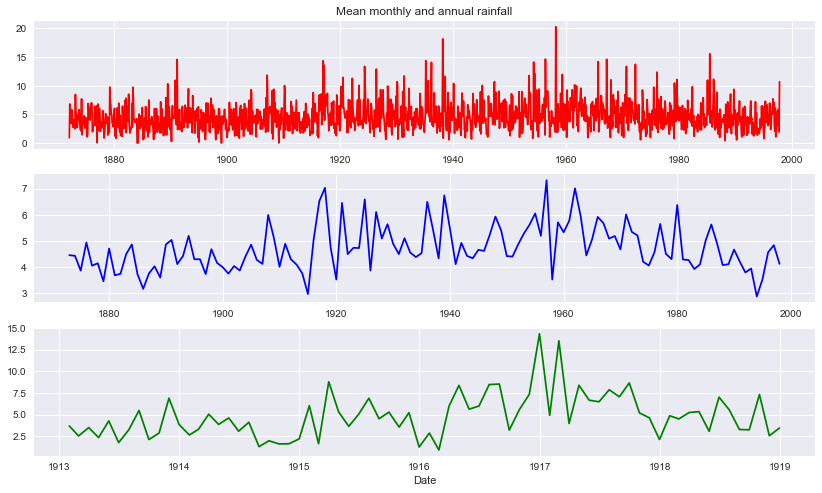

In [12]:
%%time
#Resampling the data to the average monthly and annual values
rain_monthly = rain.resample("M").mean()
rain_annual = rain.resample("A").mean()

display(rain_monthly.head())
display(rain_annual.head())

df = rain_monthly['1913':'1918']

fig,ax = plt.subplots(3,1)
ax[0].plot(rain_monthly.index, rain_monthly['rain_value'], color='red')
ax[1].plot(rain_annual.index, rain_annual['rain_value'], color='blue')
ax[2].plot(df.index, df['rain_value'], color='green')

ax[2].set_xlabel('Date')
ax[0].set_title('Mean monthly and annual rainfall')

### 11. Finding percentage of change using pct.change()

Percentage of change is applied to the mean annual data.

       rain_value
count  125.000000
mean     0.022794
std      0.226423
min     -0.518641
25%     -0.132017
50%     -0.006179
75%      0.133601
max      0.832426


Text(0.5, 1.0, 'Percentage of change from year to year')

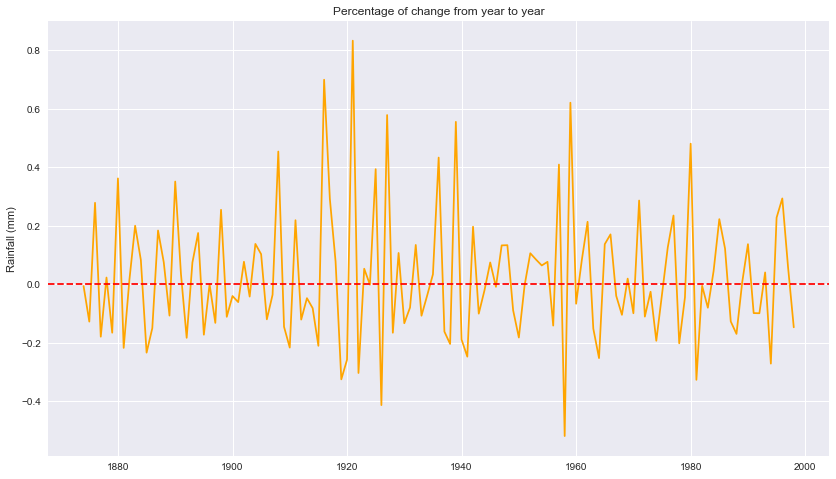

In [13]:
annual_change = rain_annual.pct_change()
print(annual_change.describe())

fig,ax = plt.subplots()
ax.plot(annual_change.index, annual_change['rain_value'], color ='orange')
ax.axhline(0,color='red', linestyle = '--')
ax.set_ylabel('Rainfall (mm)')
ax.set_title('Percentage of change from year to year')

### 12. Finding correlation using corr() function

There is no correlation between different parts of the rain-fall time series data. This part presents an example of the correlation coefficient calculated by using percent of the change and the corr() function. 

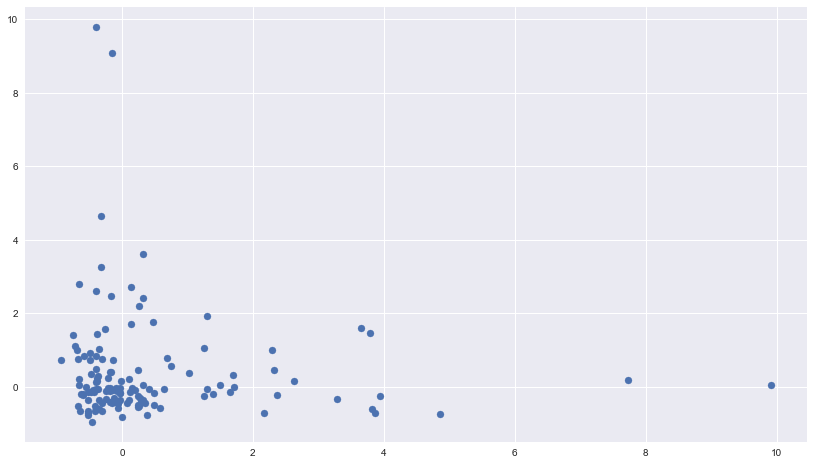

In [14]:
#percent of change
rain1c = rain_monthly['1923':'1933'].pct_change()
rain2c = rain_monthly['1934':'1944'].pct_change()

#correlation coefficient
correlation = rain1c['rain_value'].corr(rain2c['rain_value'])

plt.scatter(rain1c['rain_value'], rain2c['rain_value'])
plt.show()

### 13. Rolling windows

Above plots do not show clear patterns and trends. We can apply another technique called "rolling window" to see if time series variations will become more promenant. By applying a rolling window with mean aggregate function, the calculated values will include the mean of all the previous data.

Wall time: 45.4 ms


Text(0.5, 0, 'Date')

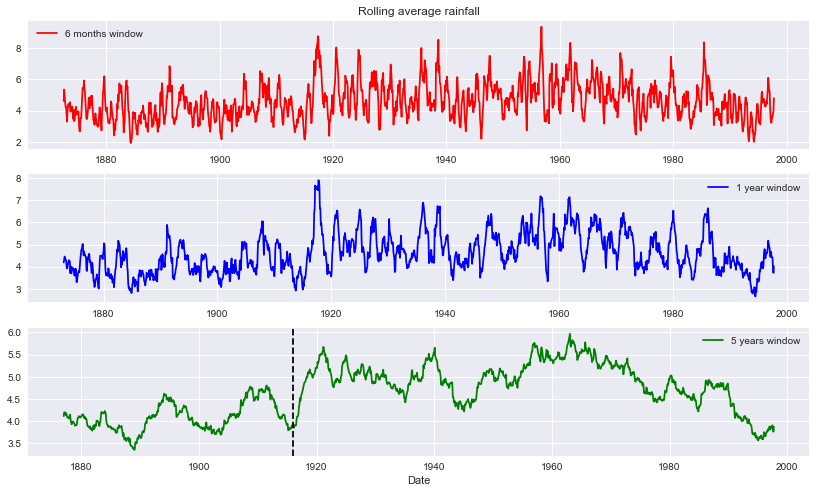

In [15]:
%%time
#6 months, 12 months and 5 years rolling average data
rain_monthly_rw = rain_monthly.rolling(6).mean()
rain_annual_rw = rain_monthly.rolling(12).mean()
rain_annual_rw2 = rain_monthly.rolling(60).mean()

fig,ax = plt.subplots(3,1)
ax[0].plot(rain_monthly_rw.index, rain_monthly_rw['rain_value'], color = 'red')
ax[1].plot(rain_annual_rw.index, rain_annual_rw['rain_value'], color = 'blue')
ax[2].plot(rain_annual_rw2.index, rain_annual_rw2['rain_value'], color = 'green')
ax[2].axvline('1916', color='black', linestyle = '--')

ax[0].set_title('Rolling average rainfall')
ax[0].legend(['6 months window'])
ax[1].legend(['1 year window'])
ax[2].legend(['5 years window'])
ax[2].set_xlabel('Date')

### 14. Zooming monthly rolling windows

By zooming three different periods, rainfall data variations can be noticed more clearly. 

Text(0.5, 0, 'Date')

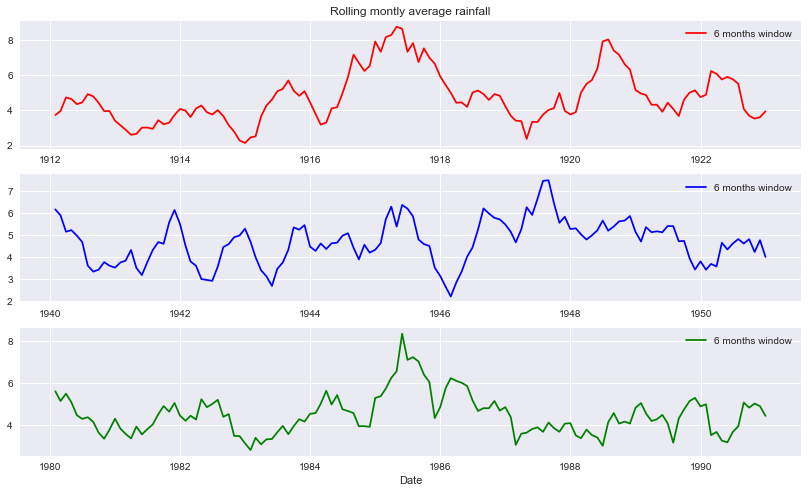

In [16]:
df1 = rain_monthly_rw['1912': '1922']
df2 = rain_monthly_rw['1940': '1950']
df3 = rain_monthly_rw['1980': '1990']

fig,ax = plt.subplots(3,1)
ax[0].plot(df1.index, df1['rain_value'], color = 'red')
ax[1].plot(df2.index, df2['rain_value'], color = 'blue')
ax[2].plot(df3.index, df3['rain_value'], color = 'green')

ax[0].set_title('Rolling montly average rainfall')
ax[0].legend(['6 months window'])
ax[1].legend(['6 months window'])
ax[2].legend(['6 months window'])
ax[2].set_xlabel('Date')

### 15. Examining extreme changes in rainfall around the year 1914

We can zoom and examine visually if rainfall data are missing around the year 1914. Measurements show no change in the frequency of data collection, only a decrease in the recorded rain values. 

Wall time: 75.5 ms


Text(0, 0.5, 'Mean rainfall (mm)')

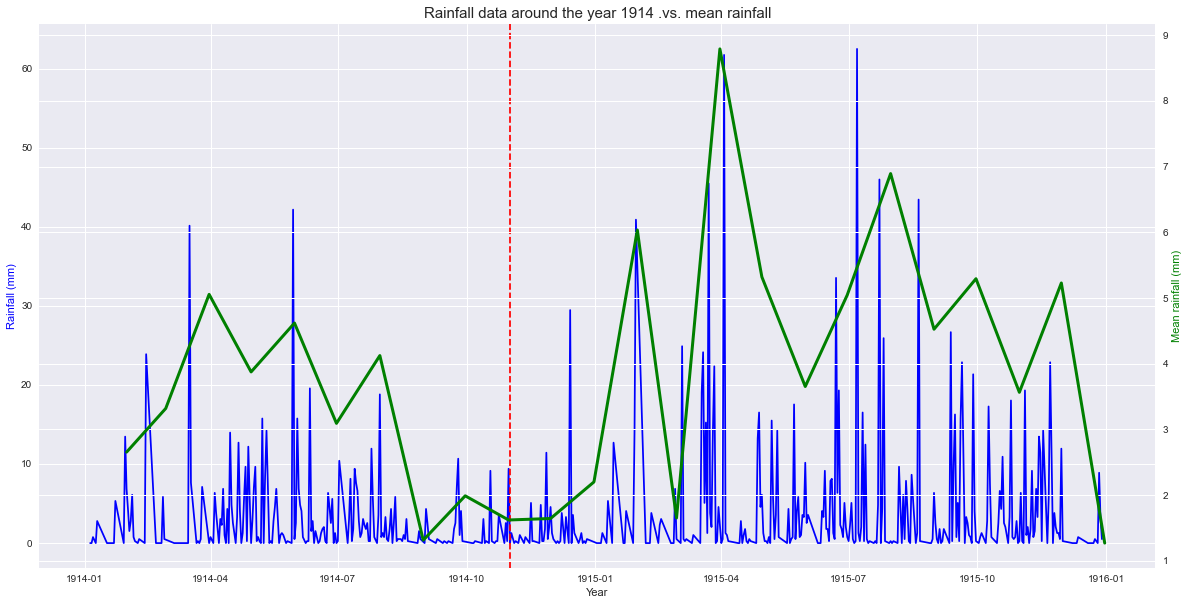

In [17]:
%%time
rain_1020 = rain['1914': '1915']

#mean rolling window
df = rain_monthly['1914': '1915']

fig,ax = plt.subplots(figsize = (20,10))
ax.plot(rain_1020.index, rain_1020['rain_value'], color = 'b')

ax.set_xlabel('Year')
ax.set_ylabel('Rainfall (mm)', color = 'b')
ax.set_title('Rainfall data around the year 1914 .vs. mean rainfall', fontsize=15)
ax.axvline('1914-11', color = 'red', linestyle = '--')

ax2 = ax.twinx()
ax2.plot(df.index, df['rain_value'], color = 'g', linewidth=3)
ax2.set_ylabel('Mean rainfall (mm)',color = 'g')


### 16. Plotting bar graph of monthly rainfall

After grouping rain values for each month and calculating medians to exclude the outliers in the records, we can display a bar graph showing approximately distribution of monthly rainfall. 

Wall time: 29.1 ms


Text(0.5, 1.0, 'Median monthly rainfall')

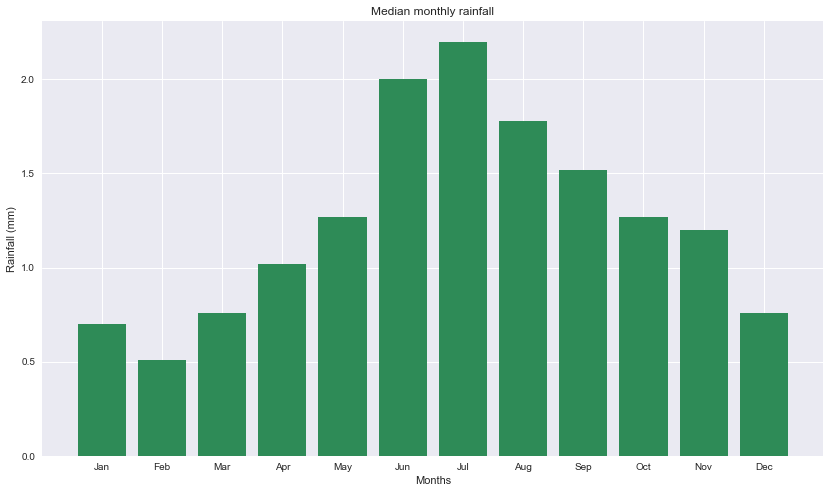

In [18]:
%%time
rain_new = rain.groupby(rain.index.month).median()

#column with months names
months = [calendar.month_abbr[i] for i in range(1,13)]
rain_new.index = months

fig,ax = plt.subplots( )
ax.bar(rain_new.index, rain_new['rain_value'], color = 'seagreen')
ax.set_xlabel('Months')
ax.set_ylabel('Rainfall (mm)')
ax.set_title('Median monthly rainfall')